#### Get the pathways database edge data for the nodes in heme_network. From our heme knowledge model we iterate through each node and see if its present in the pathway database(combined KEGG, Reactome and WikiPathways). If the node is present we try to get the edge data corresponding to that node.

In [1]:
import os
import sys
import time
import pybel
import logging
import pybel_tools

from pybel_jupyter import to_jupyter # Visualize network
from pybel.struct.mutation import collapse_all_variants, collapse_to_genes
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn2_unweighted, venn3_unweighted

from bio2bel_kegg import Manager as KeggManager
from bio2bel_reactome import Manager as ReactomeManager
from bio2bel_wikipathways import Manager as WikipathwaysManager
from pybel.constants import ANNOTATIONS, RELATION
from collections import Counter, defaultdict

import heme_knowledge

In [2]:
sys.version

'3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]'

In [3]:
time.asctime()

'Sat Jun  8 21:36:59 2019'

In [4]:
pybel.get_version()

'0.13.2'

In [5]:
merged_network = heme_knowledge.get_graph()

In [6]:
merged_network.summarize()

Heme Curation v0.0.1-dev
Number of Nodes: 764
Number of Edges: 2999
Number of Citations: 46
Number of Authors: 330
Network Density: 5.14E-03
Number of Components: 11
Number of Warnings: 0


In [7]:
collapse_to_genes(merged_network) #collapsing all proteins to genes for the sake of simplification and to map it on to the pathway graph

In [8]:
universe = pybel.from_pickle("C:/Users/syedf/.pathme/universe/pathme_universe_bel_graph.bel.pickle")

In [9]:
universe.summarize()

PathMe Universe v1.0.0
Number of Nodes: 32772
Number of Edges: 136771
Number of Citations: 6975
Number of Authors: 0
Network Density: 1.27E-04
Number of Components: 7024
Number of Warnings: 0


In [10]:
pathway_merged = set(
    node.name
    for node in universe.nodes()
    if isinstance(node, pybel.dsl.BaseAbundance)
)

In [11]:
heme_model_names = set(
    node.name
    for node in merged_network.nodes()
    if isinstance(node, pybel.dsl.BaseAbundance)
)


In [12]:
overlap = pathway_merged.intersection(heme_model_names)

In [13]:
len(overlap)

149

### Venn diagrams of nodes evluating similarity across the overlaped networks

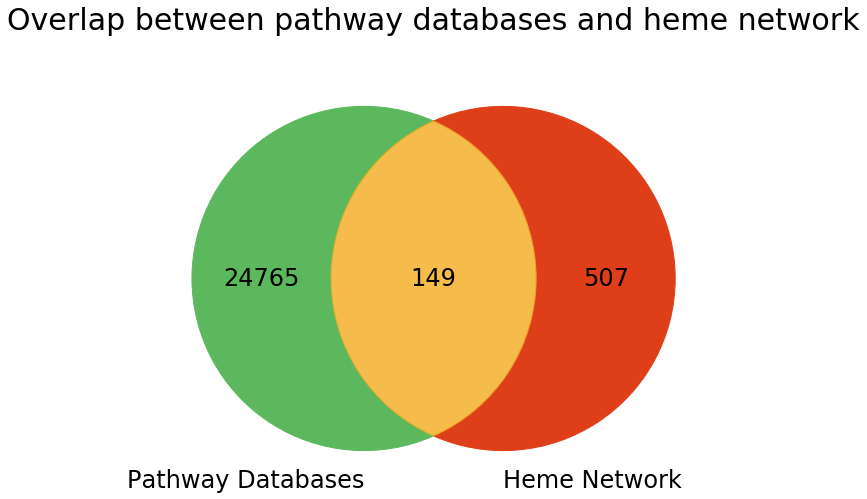

In [14]:
plt.figure(figsize=(10, 10))
out = venn2_unweighted([pathway_merged, heme_model_names], set_labels = ('Pathway Databases', 'Heme Network'))

for text in out.set_labels:
    text.set_fontsize(24)
for text in out.subset_labels:
    text.set_fontsize(24)
    
plt.title('Overlap between pathway databases and heme network\n', fontsize=30)
        
out.get_patch_by_id('10').set_color('#5cb85c')
out.get_patch_by_id('01').set_color('#df3f18')
out.get_patch_by_id('11').set_color('#f3ac1f')
out.get_patch_by_id('10').set_alpha(1.0)
out.get_patch_by_id('01').set_alpha(1.0)
out.get_patch_by_id('11').set_alpha(0.8)

plt.savefig('C:/Users/syedf/OneDrive/Thesis/ThesisLatex_Farah/img/global_overlap.png', dpi=300, bbox_inches='tight')

plt.show()


In [15]:
heme_model_names

{'2-(2-amino-3-methoxyphenyl)chromen-4-one',
 "3',5'-cyclic GMP",
 '3-nitrotyrosine',
 '4-hydroxynon-2-enal',
 '5,6-epoxycholesterol',
 'ABO-incompatible erythrocytes',
 'ADAMTS13',
 'ALAD',
 'ALB',
 'AMBP',
 'ANXA5',
 'APP',
 'ARG1',
 'ATP',
 'Abnormality of blood circulation',
 'Acta2',
 'Acute Chest Syndrome',
 'Acute Kidney Injury',
 'Acute Lung Injury',
 'Acute kidney injury',
 'Adenosine Diphosphate',
 'Alarmins',
 'Alb',
 'Aldehydes',
 'Anemia',
 'Anemia, Sickle Cell',
 'Anemia, acute',
 'Anemia, subacute',
 'Antibody Specificity',
 'Apoptosis',
 'Arginase',
 'Arterial occlusion',
 'Arterial thrombosis',
 'Arthritis',
 'Atheroma lipid',
 'Atheromatous lesions',
 'Atherosclerosis',
 'Atypical Hemolytic Uremic Syndrome',
 'BACH1',
 'Bach1',
 'Bacterial Load',
 'Biliverdine',
 'Blood Coagulation',
 'Blood Coagulation Disorders',
 'Blood Flow Velocity',
 'Blood Gas Monitoring, Transcutaneous',
 'Blood Group Incompatibility',
 'Blood Loss, Surgical',
 'Blood Platelets',
 'Blood Press

In [16]:
common_names = list(pathway_merged.intersection(heme_model_names)) #see which names are common

In [17]:
common_nodes = list(set(merged_network.nodes()).intersection(set(universe.nodes()))) #see which nodes are common

In [18]:
len(common_nodes)   

138

In [19]:
kegg_manager = KeggManager()
reactome_manager = ReactomeManager()
wp_manager = WikipathwaysManager()

In [20]:
def get_pathway_names_from_node(graph, node):
    
    pathway_ids = get_pathway_ids_from_node(graph, node)
    
    #print(f"total of {len(pathway_ids)} found from graph")

    return get_pathway_names(pathway_ids)


def get_pathway_ids_from_node(graph, node):
    """Get the pathways that the node participates in.
    
    :graph: Graph containing pathway annotations that you want
    :node: node to look up coming from heme
    """
    if node not in graph:
        return None
    
    pathways = set()
        
    # Iterate through all the edges and check if the
    for source, target, data in graph.edges(data=True):
        if source == node or target == node:
        
            if ANNOTATIONS not in data:
                continue
            
            pathways_in_edge = data[ANNOTATIONS]["PathwayID"]

            for pathway in pathways_in_edge:
                pathways.add(pathway.strip("_unflatten"))
    return pathways


def get_pathway_names(pathway_ids):
    """Get the pathways that the node participates in.
    
    :graph: Graph containing pathway annotations that you want
    :node: node to look up coming from heme
    """
    
    kegg_manager = KeggManager()
    reactome_manager = ReactomeManager()
    wp_manager = WikipathwaysManager()
    
    pathway_names = list()
    
    for pathway in pathway_ids:
        
        if pathway.startswith("R-HSA"):
            
            pathway_object = reactome_manager.get_pathway_by_id(pathway)
            
            if not pathway_object:
                print(f"{pathway} not found")
                continue
                
            pathway_names.append(pathway_object.name)
            
        elif pathway.startswith("WP"):
            pathway_object = wp_manager.get_pathway_by_id(pathway)
            
            if not pathway_object:
                print(f"{pathway} not found")
                continue
            
            pathway_names.append(pathway_object.name)  #append the name for the id

        
        elif pathway.startswith("hsa"):
            pathway_object = kegg_manager.get_pathway_by_id("path:"+pathway)
            
            if not pathway_object:
                print(f"{pathway} not found")
                continue

            pathway_names.append(pathway_object.name)

        else:
            print(f"{pathway} not found")
            
    return pathway_names


def get_pathways_from_nodes(graph, nodes):
    """This funtion makes a dictionary of node: pathway_names"""
  
    id_dic = {}
    
    for node in nodes:
        id_dic[node] = get_pathway_names_from_node(graph, node)
        
    return id_dic


Proportion of pathways match the number of pathways by resource

In [21]:
def get_pathways_from_nodes(graph, nodes):
    """This funtion makes a dictionary of node: pathway_names"""
  
    id_dic = {}
    
    for node in nodes: #nodes that are common in the merged pathways and heme model
        id_dic[node] = get_pathway_ids_from_node(graph, node)
        
    return id_dic

pathways_by_ids = get_pathways_from_nodes(universe, common_nodes)

num_of_kegg_in_merged = 0
num_of_reactome_in_merged = 0
num_of_wikipathways_in_merged = 0

for k, v in pathways_by_ids.items():
    for pathway_id in v:
        
        if pathway_id.startswith('hsa'):
            num_of_kegg_in_merged += 1
        elif pathway_id.startswith('R-HSA'):
            num_of_reactome_in_merged += 1
        elif pathway_id.startswith('WP'):
            num_of_wikipathways_in_merged += 1
        else:
            raise ValueError(f'Invalid pathway ID {pathway_id}.')

total = (num_of_kegg_in_merged + num_of_reactome_in_merged + num_of_wikipathways_in_merged)
            
print(num_of_kegg_in_merged, ":are from KEGG")
print(num_of_reactome_in_merged, ":are from Reactome")
print(num_of_wikipathways_in_merged, ":are from Wikipathways")

601 :are from KEGG
998 :are from Reactome
327 :are from Wikipathways


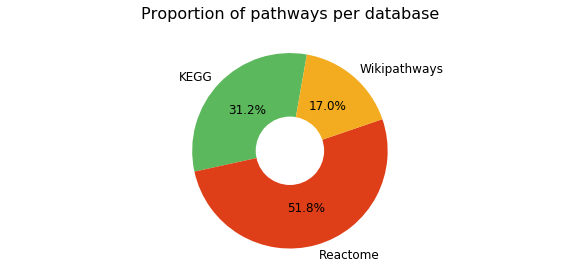

In [22]:
kegg = round(num_of_kegg_in_merged/total*100,2)
reac = round(num_of_reactome_in_merged/total*100,2)
wiki = round(num_of_wikipathways_in_merged/total*100,2)

# Pie chart
labels = ['KEGG', 'Reactome', 'Wikipathways']
sizes = [kegg, reac, wiki]
#add colors
colors = ['#5cb85c','#df3f18','#f3ac1f']

fig1, ax1 = plt.subplots(figsize=(10, 4))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=80, textprops={'fontsize': 12})

centre_circle = plt.Circle((0,0),0.35,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Proportion of pathways per database\n', size = 16)
  
plt.savefig('C:/Users/syedf/OneDrive/Thesis/ThesisLatex_Farah/img/pathway_proportion.png', dpi=300, bbox_inches='tight')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')

plt.show()

In [23]:
mapping_pathway_ids = get_pathway_ids_from_node(universe, common_nodes[12])

In [24]:
mapping_pathway_ids

{'R-HSA-75205'}